<a href="https://colab.research.google.com/github/najiyak23/Building-a-Reviewer-Trust-Score/blob/main/%F0%9F%8F%86_Building_a_Reviewer_Trust_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pratyushpuri/multilingual-mobile-app-reviews-dataset-2025")

print("Path to dataset files:", path)

100%|██████████| 133k/133k [00:00<00:00, 56.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/pratyushpuri/multilingual-mobile-app-reviews-dataset-2025/versions/1


In [3]:
import os
print(os.listdir(path))

['multilingual_mobile_app_reviews_2025.csv']


In [4]:


# Load the dataset into a DataFrame
df = pd.read_csv(path + "/multilingual_mobile_app_reviews_2025.csv")

# Inspect the shape and first few rows
print(df.shape)
df.head()

(2514, 15)


,review_id,user_id,app_name,app_category,review_text,review_language,rating,review_date,verified_purchase,device_type,num_helpful_votes,user_age,user_country,user_gender,app_version
0,1,1967825,MX Player,Travel & Local,Qui doloribus consequuntur. Perspiciatis tempo...,no,1.3,2024-10-09 19:26:40,True,Android Tablet,65,14.0,China,Female,1.4
1,2,9242600,Tinder,Navigation,"Great app but too many ads, consider premium v...",ru,1.6,2024-06-21 17:29:40,True,iPad,209,18.0,Germany,Male,8.9
2,3,7636477,Netflix,Dating,The interface could be better but overall good...,es,3.6,2024-10-31 13:47:12,True,iPad,163,67.0,Nigeria,Male,2.8.37.5926
3,4,209031,Venmo,Productivity,"Latest update broke some features, please fix ...",vi,3.8,2025-03-12 06:16:22,True,iOS,664,66.0,India,Female,10.2
4,5,7190293,Google Drive,Education,"Perfect for daily use, highly recommend to eve...",tl,3.2,2024-04-21 03:48:27,True,iPad,1197,40.0,South Korea,Prefer not to say,4.7


In [5]:
# Select only the columns we need
df = df[['user_id', 'review_text', 'rating', 'review_date',
         'num_helpful_votes', 'verified_purchase']].copy()

# Rename for clarity
df.columns = ['reviewer_id', 'review_text', 'rating', 'review_date',
              'helpful_votes', 'verified_purchase']

# Convert datatypes
df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Drop missing values in critical columns
df = df.dropna(subset=['reviewer_id', 'review_text', 'rating', 'review_date'])

# Clip ratings between 1 and 5
df['rating'] = df['rating'].clip(1, 5)

# Add review length feature
df['review_length_words'] = df['review_text'].astype(str).str.split().map(len)

df.head()


,reviewer_id,review_text,rating,review_date,helpful_votes,verified_purchase,review_length_words
0,1967825,Qui doloribus consequuntur. Perspiciatis tempo...,1.3,2024-10-09 19:26:40,65,True,10
1,9242600,"Great app but too many ads, consider premium v...",1.6,2024-06-21 17:29:40,209,True,9
2,7636477,The interface could be better but overall good...,3.6,2024-10-31 13:47:12,163,True,9
3,209031,"Latest update broke some features, please fix ...",3.8,2025-03-12 06:16:22,664,True,8
4,7190293,"Perfect for daily use, highly recommend to eve...",3.2,2024-04-21 03:48:27,1197,True,8


In [6]:
import numpy as np

# Group by reviewer
reviewer_stats = df.groupby('reviewer_id').agg(
    num_reviews = ('review_text', 'count'),
    avg_rating = ('rating', 'mean'),
    rating_stddev = ('rating', 'std'),
    avg_review_length = ('review_length_words', 'mean'),
    avg_helpful_votes = ('helpful_votes', 'mean'),
    verified_ratio = ('verified_purchase', 'mean'),
    last_review_date = ('review_date', 'max')
).reset_index()

# Handle NaNs (e.g. stddev for single review users)
reviewer_stats['rating_stddev'] = reviewer_stats['rating_stddev'].fillna(0)

# Add recency feature (reviews in last 180 days)
cutoff_date = df['review_date'].max() - pd.Timedelta(days=180)
recent_reviews = df[df['review_date'] >= cutoff_date].groupby('reviewer_id').size()
reviewer_stats['recent_reviews'] = reviewer_stats['reviewer_id'].map(recent_reviews).fillna(0)

reviewer_stats.head()


,reviewer_id,num_reviews,avg_rating,rating_stddev,avg_review_length,avg_helpful_votes,verified_ratio,last_review_date,recent_reviews
0,100599,1,1.7,0.0,9.0,1196.0,1.0,2023-11-27 17:37:01,0.0
1,103092,1,4.6,0.0,9.0,759.0,1.0,2025-03-10 22:01:48,1.0
2,106810,1,4.3,0.0,7.0,339.0,1.0,2024-03-23 21:43:04,0.0
3,108991,1,3.8,0.0,6.0,634.0,0.0,2023-09-10 08:51:50,0.0
4,126484,1,3.7,0.0,9.0,656.0,1.0,2023-10-15 02:52:43,0.0


🔄 Step 5 — Normalize Features

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Pick features we want in the Trust Score
features = ['num_reviews','avg_rating','rating_stddev',
            'avg_review_length','avg_helpful_votes',
            'verified_ratio','recent_reviews']

reviewer_stats_scaled = reviewer_stats.copy()
reviewer_stats_scaled[features] = scaler.fit_transform(reviewer_stats[features])

reviewer_stats_scaled.head()


,reviewer_id,num_reviews,avg_rating,rating_stddev,avg_review_length,avg_helpful_votes,verified_ratio,last_review_date,recent_reviews
0,100599,0.0,0.175,0.0,0.380952,0.957566,1.0,2023-11-27 17:37:01,0.0
1,103092,0.0,0.900,0.0,0.380952,0.607686,1.0,2025-03-10 22:01:48,1.0
2,106810,0.0,0.825,0.0,0.285714,0.271417,1.0,2024-03-23 21:43:04,0.0
3,108991,0.0,0.700,0.0,0.238095,0.507606,0.0,2023-09-10 08:51:50,0.0
4,126484,0.0,0.675,0.0,0.380952,0.525220,1.0,2023-10-15 02:52:43,0.0


🧮 Step 6 — Define a Trust Score Formula

In [8]:
# Define weights
weights = {
    'num_reviews': 0.2,
    'rating_stddev': 0.15,
    'avg_review_length': 0.1,
    'avg_helpful_votes': 0.25,
    'verified_ratio': 0.15,
    'recent_reviews': 0.15
}

# Compute trust score
reviewer_stats_scaled['trust_score'] = (
    reviewer_stats_scaled['num_reviews'] * weights['num_reviews'] +
    reviewer_stats_scaled['rating_stddev'] * weights['rating_stddev'] +
    reviewer_stats_scaled['avg_review_length'] * weights['avg_review_length'] +
    reviewer_stats_scaled['avg_helpful_votes'] * weights['avg_helpful_votes'] +
    reviewer_stats_scaled['verified_ratio'] * weights['verified_ratio'] +
    reviewer_stats_scaled['recent_reviews'] * weights['recent_reviews']
)

# Sort reviewers by trust
leaderboard = reviewer_stats_scaled.sort_values('trust_score', ascending=False)
leaderboard.head(10)


,reviewer_id,num_reviews,avg_rating,rating_stddev,avg_review_length,avg_helpful_votes,verified_ratio,last_review_date,recent_reviews,trust_score
1058,4465936,0.0,0.250,0.0,0.952381,0.955164,1.0,2025-04-18 18:27:52,1.0,0.634029
796,3340180,0.0,0.125,0.0,0.952381,0.940753,1.0,2025-02-01 09:47:37,1.0,0.630426
1771,7379693,0.0,0.100,0.0,0.952381,0.913531,1.0,2025-03-05 18:22:20,1.0,0.623621
2320,9634543,0.0,0.875,0.0,0.904762,0.904724,1.0,2025-05-11 05:14:39,1.0,0.616657
9,160407,0.0,0.350,0.0,0.666667,0.976781,1.0,2025-06-17 04:37:21,1.0,0.610862
1598,6740184,0.0,0.950,0.0,0.666667,0.887110,1.0,2025-05-09 11:12:38,1.0,0.588444
703,2981270,0.0,0.775,0.0,0.380952,1.000000,1.0,2025-04-04 22:05:42,1.0,0.588095
108,636367,0.0,0.050,0.0,0.380952,0.996797,1.0,2025-04-18 13:12:37,1.0,0.587295
2153,8961040,0.0,0.800,0.0,0.380952,0.988791,1.0,2025-07-14 19:19:03,1.0,0.585293
2303,9557911,0.0,0.825,0.0,0.380952,0.983987,1.0,2025-03-13 02:12:54,1.0,0.584092


📊 Step 7 — Visualize Top 10 Reviewers

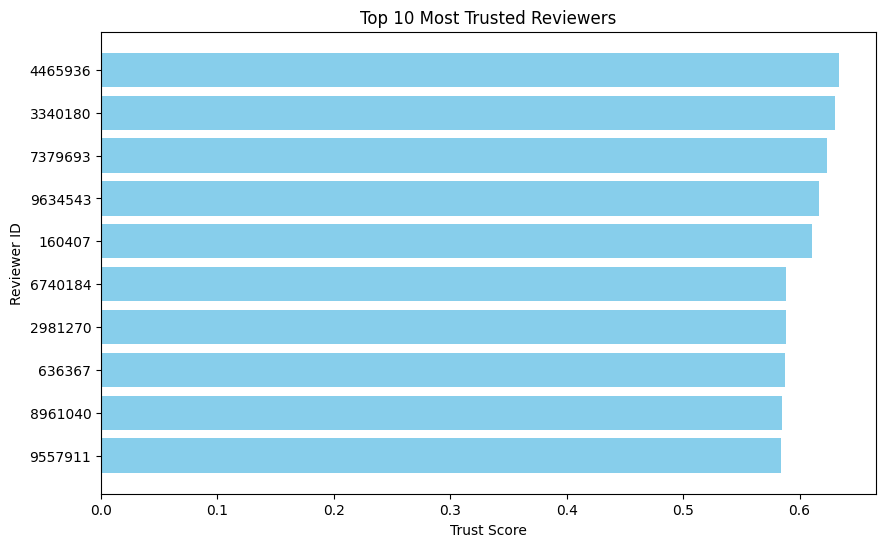

In [9]:
import matplotlib.pyplot as plt

# Pick top 10 reviewers
top10 = leaderboard.head(10)

plt.figure(figsize=(10,6))
plt.barh(top10['reviewer_id'].astype(str), top10['trust_score'], color='skyblue')
plt.xlabel("Trust Score")
plt.ylabel("Reviewer ID")
plt.title("Top 10 Most Trusted Reviewers")
plt.gca().invert_yaxis()  # highest at top
plt.show()




📉 Step 8 — Trust Score Distribution

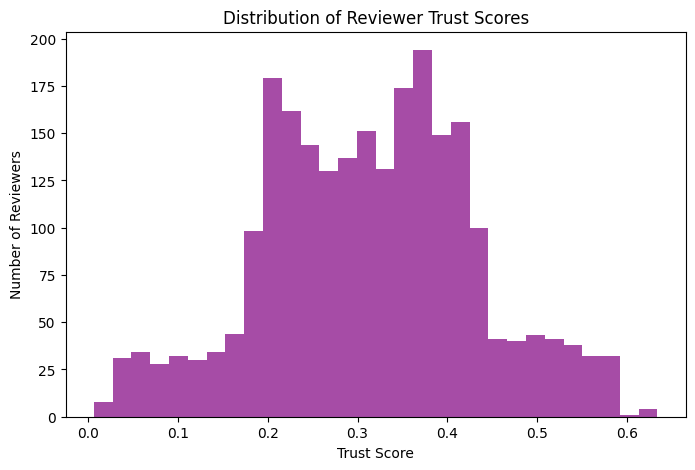

In [10]:
plt.figure(figsize=(8,5))
plt.hist(leaderboard['trust_score'], bins=30, color='purple', alpha=0.7)
plt.xlabel("Trust Score")
plt.ylabel("Number of Reviewers")
plt.title("Distribution of Reviewer Trust Scores")
plt.show()
